## <center> **Анализ результатов A/B-тестирования**

Туроператор планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование.

<u>Бизнес задача:</u> проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку.  
 На основе проведенного анализа сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

#### Импорт библиотек и чтение данных

In [653]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [654]:
data = pd.read_csv('ab_data_tourist.csv')
data = data.copy()
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


## **Задание 7.1.**
Какой тип данных имеет столбец date?

In [655]:
display(data.info())
data['date'].dtype
# Тип данных у признака date - object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

dtype('O')

## **Задание 7.2.**

Убедитесь в равной длительности проведения тестирования для каждой из группы.  
Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [656]:
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
data_group = data.groupby(['group'])['date'].agg(['min', 'max'])
data_group
print('Тест проводился с ', data_group['min'][0],'по',data_group['max'][0])

Тест проводился с  2021-01-02 по 2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [657]:
A_count = data[data['group'] == 'A']['user_id'].count()
B_count = data[data['group'] == 'B']['user_id'].count()
print(f'Количество посещений сайта в группе А {A_count}, в группе B {B_count}')

A_sum = data[data['group'] == 'A']['purchase'].sum()
B_sum = data[data['group'] == 'B']['purchase'].sum()
print(f'Количество покупок в группе А {A_sum}, в группе B {B_sum}')

A_sum = (data[data['group'] == 'A']['price'].sum())/1e6
B_sum = (data[data['group'] == 'B']['price'].sum())/1e6
print(f'Общая сумма покупок в группе А {A_sum: .2f} млн. руб., в группе B {B_sum: .2f} млн. руб.')



Количество посещений сайта в группе А 147202, в группе B 147276
Количество покупок в группе А 17723, в группе B 17514
Общая сумма покупок в группе А  1436.26 млн. руб., в группе B  1554.10 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [658]:
data_a = set(data[data['group'] == 'A']['user_id'])
data_b = set(data[data['group'] == 'B']['user_id'])
print(f'Количество уникальных пользователей в обеих группах {len(data_a.intersection(data_b))}')

Количество уникальных пользователей в обеих группах 1895


Исключаем пересечённых пользователей:

In [659]:
user_intersection = data_a.intersection(data_b)
data = data[data['user_id'].apply(lambda x: x not in user_intersection)]


## **Задание 7.5.**


Группируем данные по признаку группы.
* количество посещений
* количество совершенных покупок
* сумма всех покупок в группе


Чему на этот раз равно количество посещений сайта в группах А и B?


In [660]:
regroup_data = data.groupby('group')['user_id', 'purchase', 'price'].agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).reset_index()
regroup_data = regroup_data.rename({'user_id':'count_visits', 'purchase':'count_purchases', 'price':'sum_price'})
regroup_data

,group,user_id,purchase,price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество посещений обоих вариантов посадочной странице в разных группах почти равны. Можно сказать, что выборки сбалансированны.  
Сами выборки достаточно большие для проведения теста.

## **Задание 7.6.**


* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [661]:
regroup_data["mean_check"] = round(regroup_data["price"]/regroup_data['purchase'])
regroup_data["conversion"] = round(regroup_data['purchase']/regroup_data['user_id']*100, 2)
regroup_data

,group,user_id,purchase,price,mean_check,conversion
0,A,145307,17487,1417780000,81076.0,12.03
1,B,145381,17290,1533010000,88665.0,11.89


По предварительным оценкам можно предположить, что по показателю конверсии эффектианее вариант А, но средний чек выше у группы В.  
В любом случае, пока рано делать точные выводы, нужно провести дальнейшие тесты

## **Задание 7.7.**

Построить сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [662]:
pivot_data = data.pivot_table(values='purchase', index='group', columns = ['price'], aggfunc={'purchase':'sum'})
pivot_data = pivot_data.drop(columns=0)
display(pivot_data.iloc[:, 1])


group
A    5271
B    1730
Name: 60000, dtype: int64

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot: xlabel='price', ylabel='group'>

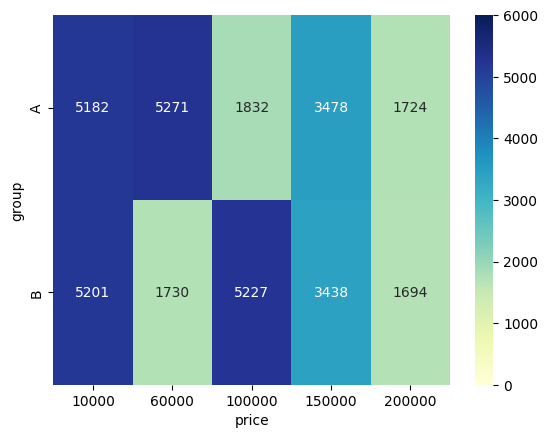

In [663]:
sns.heatmap(pivot_data, annot=True, vmin=0, vmax=6000, cmap="YlGnBu", fmt=".0f")

По тепловой карте видно, что при цене тура в 10000 рублей количества продаж примерно одинаковы.  
При 60000 в группе А количество больше.  
А при 100000 рублей наоборот - в группе А меньше, чем в В.
При 150000 и 200000 - также примерно равны.  
О какой-то зависимости сложно говорить. Но заметна тенденция на уменьшение количества продаж вцелом при увеличении цены.


## **Задание 7.8.**

Добавим в таблицу информацию о ежедневной конверсиив группе и ежедневном среднем чеке
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [664]:
group_date = data.groupby(['group', 'date']).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})

group_date['conversion'] = group_date['purchase']/group_date['user_id']*100
group_date['daily_check'] = round(group_date['price']/group_date['purchase'], 2)

print_data = group_date.reset_index()
print('Конверсия за 3 января 2021 года:', print_data[print_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2), sep='\n')
print('Средний чек за 3 января 2021 года:', print_data[print_data['date'] == pd.to_datetime('2021-01-03')][['group', 'daily_check']].round(2), sep='\n')

Конверсия за 3 января 2021 года:
   group  conversion
1      A       11.34
24     B       11.39
Средний чек за 3 января 2021 года:
   group  daily_check
1      A     82887.70
24     B     87480.11


## **Задание 7.9.** 

Добавим:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок
* кумулятивную конверсию
* кумулятивный средний чек

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [665]:

group_date['cum_visit'] = group_date.groupby(['group'])['user_id'].cumsum()
group_date['cum_purchase'] = group_date.groupby(['group'])['purchase'].cumsum()
group_date['cum_price'] = group_date.groupby(['group'])['price'].cumsum()

group_date['cum_conversion'] = group_date['cum_purchase']/group_date['cum_visit']*100
group_date['cum_daily_check'] = group_date['cum_price']/group_date['cum_purchase']
group_date = group_date.reset_index()

print(
    'Кумулятивная конверсия в группе B на 20 января:', 
    group_date[(group_date['date'] == pd.to_datetime('2021-01-20')) & (group_date['group'] == 'B')]['cum_conversion'].round(2), 
    sep='\n'
    )
print(
    'Кумулятивный средний чек в группе А на 12 января 2021 года:', 
    group_date[(group_date['date'] == pd.to_datetime('2021-01-12')) & (group_date['group'] == 'A')]['cum_daily_check'].round(), 
    sep='\n'
    )

Кумулятивная конверсия в группе B на 20 января:
41    11.9
Name: cum_conversion, dtype: float64
Кумулятивный средний чек в группе А на 12 января 2021 года:
10    81492.0
Name: cum_daily_check, dtype: float64


Построим кумулятивные графики конверсии и среднего чека в каждой группе по дням. 

<AxesSubplot: xlabel='date', ylabel='cum_daily_check'>

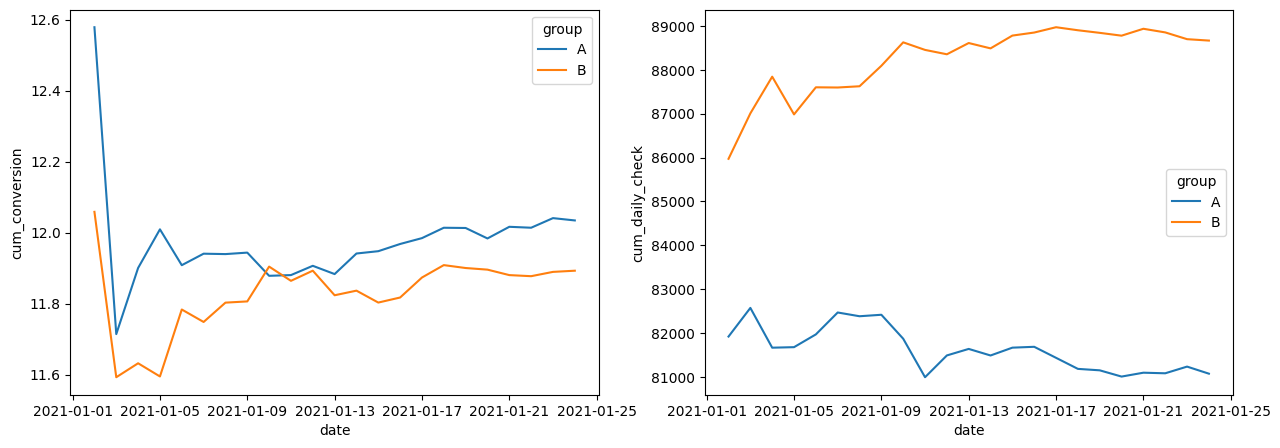

In [666]:
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='date', y='cum_conversion', data=group_date, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_daily_check', data=group_date, hue='group', ax=axes[1])


Согласно построенным графикам, можно наблюдать, что конверсия и средний чек со временем стабилизировались и не пересекаются. Поэтому можно сказать, что тест А/В завершен.  
Мы видим, что конверсия в группе А выше, чем в В, но средний чек больше в группе А.

## **Задание 7.10.**

Провести тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;



In [667]:
# считаем количество успешных действий и количество наблюдений
z_data = data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)

# Устанавливаем гипотезы: 
H0 = 'конверсии в группах А и B равны'
H1 = 'конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста
_, p_value = proportions_ztest(
    count=z_data['sum'], #число успешных действий
    nobs=z_data['count'], #все наблюдения
    alternative='smaller')


print('p-value: ', round(p_value, 2))

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза - {}".format(H1))
else:
    print("Принимаем нулевую гипотезу, что {}".format(H0))

p-value:  0.88
Принимаем нулевую гипотезу, что конверсии в группах А и B равны


Исходя из совершённого теста моэно сказать, что статистической разницы между конверсиями в группах А и B нет. И мы не будем отвергать нулевую гипотезу.

## **Задание 7.11.**
Подтвердить выводы предыдущего теста, построив 95%-ый доверительный интервал для конверсий и разницы между ними.

In [668]:
# группируем по группам в две таблицы
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

# Функция вычисления доверительного интервала пропорции
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# Применяю функцию к данным группы А и группы B:
# A
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
# B
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))



# Функция вычисления доверительного интервала разницы пропорций
def diff_proportions_conf_interval(na, nb, xpa, xpb, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xpb - xpa # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xpa * (1 - xpa)/na + xpb * (1 - xpb)/nb) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

na = a_data['user_id'].count()
nb = b_data['user_id'].count()

xpa = a_data['purchase'].mean()
xpb = b_data['purchase'].mean()

# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(na, nb, xpa, xpb)
print('')
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)

Доверительный интервал для разности конверсий: (-0.38, 0.09)


 Между доверительными интервалами для групп А и В есть перекрытие. Согласно проведённому тесту статистическая разница между конверсиями в группах А и B отсутствует, так как доверительный интервал для разности конверсий включает 0.

## **Задание 7.12.**

Проверим гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 


In [669]:
H0 = 'распределения в обеих группах нормальные'
H1 = 'распределение в одной или обеих группах отлично от нормального'
alpha = 0.05
# теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(group_date[group_date['group'] == 'A']['daily_check'])
shapiro_result_b = shapiro(group_date[group_date['group'] == 'B']['daily_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))


if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу, что {}".format(H0))


p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу, что распределения в обеих группах нормальные


## **Задание 7.13.**

Сравниваем варианты дизайна страницы по метрике среднего чека. 

 

In [670]:
H0 = 'ежедневные средние чеки в группах А и B равны'
H1 = 'ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=group_date[group_date['group'] == 'A']['daily_check'],
    b=group_date[group_date['group'] == 'B']['daily_check'], 
    alternative='less' # левосторонняя гипотеза
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу, что {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу, что ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза H1: ежедневный средний чек в группе А меньше чем в группе B


 Так как полученное значение p-value меньше уровня значимости в 0.05, то можно заключить, что есть статистическая разница между ежедневными средними чеками в группах А и B.

## **Задание 7.14.**

Построим 95%-ый доверительный интервал для среднего чека в каждой группе. 



In [674]:
# Функция вычисления доверительного интервала среднего значения
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)

n = group_date[group_date['group'] == 'A']['daily_check'].count()
x_mean = group_date[group_date['group'] == 'A']['daily_check'].mean()
x_std = group_date[group_date['group'] == 'A']['daily_check'].std()
print('Доверительный интервал для среднего чека группы А:', mean_check_conf_interval(n, x_mean, x_std))

n = group_date[group_date['group'] == 'B']['daily_check'].count()
x_mean = group_date[group_date['group'] == 'B']['daily_check'].mean()
x_std = group_date[group_date['group'] == 'B']['daily_check'].std()
print('Доверительный интервал для среднего чека группы В:', mean_check_conf_interval(n, x_mean, x_std))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы В: (87626, 89526)


Между интервалами нет пересечения, из чего можно заключить, что средний чек группы В однозначно больше.

## Вывод по проделанной работе